Note code is coming from Sebastian Raschka's [repo](https://github.com/rasbt/LLMs-from-scratch) covering LLMs from scratch with slight modifications

In [1]:
import tiktoken
import torch
from torch.utils.data import DataLoader, Dataset
from utils import json_to_dataframe, json_to_string_list

## Define dataloader

In [2]:
def encode_and_decode_example(list_of_strings):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Get the token ID for <|endoftext|>
    endoftext_token = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

    all_tokens = []
    for text in list_of_strings:
        # Encode the text
        encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        all_tokens.extend(encoded + [endoftext_token])

    # Decode the tokens
    decoded = tokenizer.decode(all_tokens)

    return all_tokens, decoded

In [3]:
class GPTDatasetV1(Dataset):
    def __init__(self, articles, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Get the token ID for <|endoftext|>
        endoftext_token = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

        # Tokenize all articles with end-of-text token
        all_tokens = []
        for article in articles:
            article_tokens = tokenizer.encode(article, allowed_special={"<|endoftext|>"})
            all_tokens.extend(article_tokens + [endoftext_token])

        # Use a sliding window to chunk the tokens into overlapping sequences of max_length
        for i in range(0, len(all_tokens) - max_length, stride):
            input_chunk = all_tokens[i:i + max_length]
            target_chunk = all_tokens[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [4]:
def create_dataloader_v1(articles, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(articles, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

## Load radiology reports dataset

In [5]:
filepath = '../../data/vector_veterinary_imaging.json'

df = json_to_dataframe(filepath) 
rad_strings = json_to_string_list(filepath)

In [6]:
df

,case_identifier,findings,conclusions_and_recommendations
0,181153,Orthogonal pelvis and orthogonal right shoulde...,1. Medial right mildly comminuted acetabular f...
1,181413,"Three view whole body images dated April 14, 2...",The material within the stomach and small inte...
2,181821,Three view thoracic radiographs (total of 5 th...,No aggressive osseous changes are noted. The b...
3,181886,Orthogonal images of the right pelvic limb are...,"1. Chronic right calcaneal tendonopathy, with ..."
4,181911,Lateral abdomen and pelvis images are provided...,"1. Numerous small urinary cystoliths, non-obst..."
...,...,...,...
598,215115,Ventrodorsal pelvis and and stifles and latera...,Marked bilateral stifle synovitis/synovial eff...
599,215123,Three view thorax images dated 12/1/2023 are p...,"Moderate diffuse lower airway thickening, most..."
600,215136,Three view whole body images dated 12/1/2023 a...,"Hepatosplenomegaly. Separately, these may repr..."
601,215177,Three view thoracic images dated 12/2/2023 are...,Marked left and right-sided cardiomegaly. The ...


In [7]:
len(rad_strings)

603

In [8]:
rad_strings[0]

'Findings: Orthogonal pelvis and orthogonal right shoulder and lateral left shoulder images dated April 17, 2023 are provided for review (total of 5 images). Shoulders: A sagittal plane fracture is present through the right scapular body, where the spine meets the body, extending cranially through the cranial margin of the acromion. this fracture does not articulate with the glenoid rims or the scapulohumeral joint. This fracture is visualized on the craniocaudal image, not visualized on the lateral image, thought due to superimposition. The fracture is non-displaced. Small fissures are suspected extending into the scapular spine. The right first rib is fractured in the body. A non-displaced fracture is also suspected in the body of the right second rib. The visible scapula, scapulohumeral margins, and humerus of the left shoulder are normal. The included cervical and thoracic spine is normal. Pelvis: A mildly comminuted segment fracture is present through the medial and cranial third 

## Create data pipeline

In [9]:
vocab_size = 50257
output_dim = 256
max_len = 1024
context_length = max_len

In [10]:
import torch
import torch.nn as nn

token_embedding_layer = nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [11]:
max_length = 4
dataloader = create_dataloader_v1(rad_strings, batch_size=8, max_length=max_length, stride=max_length)

In [12]:
def inspect_batch(x, y, n_samples=2):
    for i in range(min(n_samples, len(x))):
        tokenizer = tiktoken.get_encoding("gpt2")
        
        print(f"\nSample {i+1}:")
        
        # Decode and print the input sequence
        input_text = tokenizer.decode(x[i].tolist())
        print(f"Input text: {input_text}")
        print(f"Input encoding: {x[i].tolist()}")
        
        # Decode and print the target sequence
        target_text = tokenizer.decode(y[i].tolist())
        print(f"Target text: {target_text}")
        print(f"Target encoding: {y[i].tolist()}")
        
        print("-" * 50)

In [13]:
INSPECT = True

In [14]:
for batch in dataloader:
    x, y = batch

    if INSPECT:
        # Visual inspection
        inspect_batch(x, y)

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break


Sample 1:
Input text:  of 4 images).
Input encoding: [286, 604, 4263, 737]
Target text:  4 images). The
Target encoding: [604, 4263, 737, 383]
--------------------------------------------------

Sample 2:
Input text: ax in the region
Input encoding: [897, 287, 262, 3814]
Target text:  in the region of
Target encoding: [287, 262, 3814, 286]
--------------------------------------------------


In [15]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])


# Define GPT model

In [16]:
import torch.nn as nn

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [18]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [20]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# Initialize GPT

In [64]:
GPT2_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

GPT2_CONFIG_355M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1024,
    "n_heads": 16,
    "n_layers": 24,
    "drop_rate": 0.1,
    "qkv_bias": False
}

GPT2_CONFIG_774M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1280,
    "n_heads": 20,
    "n_layers": 36,
    "drop_rate": 0.1,
    "qkv_bias": False
}

GPT2_CONFIG_1558M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1600,
    "n_heads": 25,
    "n_layers": 48,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [ ]:
CONFIG = GPT_CONFIG_124M

In [ ]:
torch.manual_seed(123)
model = GPTModel(CONFIG)
model.eval();  # Disable dropout during inference

In [65]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [66]:
start_context = "The included lumbar and"
# start_context = "extending cranially through"
tokenizer = tiktoken.get_encoding("gpt2")

In [67]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=CONFIG["context_length"]
)

The model will generate random text prior to training

In [68]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 The included lumbar and Publication,' Somebody ampbase Dying counsellingilibrium Influ haul


## Explore dataset

Look at distribution of token lengths of reports, also look at token length of the entire dataset.

In [69]:
import numpy as np

In [70]:
# Calculate token length of entire dataset
entire_text = " ".join(rad_strings)
total_tokens = len(tokenizer.encode(entire_text))

print(f"Total tokens in the entire dataset: {total_tokens}")

Total tokens in the entire dataset: 220912



Token length statistics for individual strings:
Mean: 366.35
Median: 336.00
Minimum: 130
Maximum: 1554
Standard Deviation: 166.36

Percentiles:
25th: 250.50
50th: 336.00
75th: 440.50
90th: 556.00
95th: 652.50
99th: 903.92


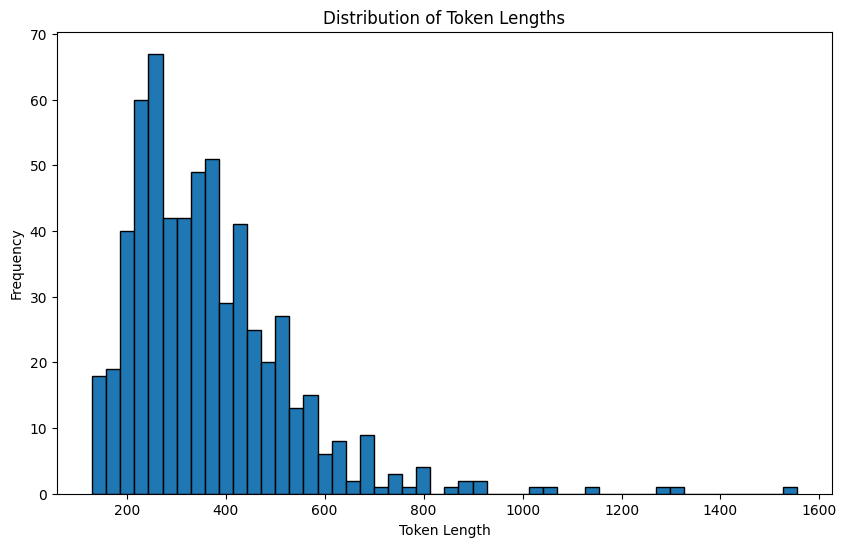

In [71]:
# Calculate token lengths for individual strings
token_lengths = [len(tokenizer.encode(s)) for s in rad_strings]

# Calculate statistics
mean_length = np.mean(token_lengths)
median_length = np.median(token_lengths)
min_length = np.min(token_lengths)
max_length = np.max(token_lengths)
std_dev = np.std(token_lengths)

# Calculate percentiles
percentiles = np.percentile(token_lengths, [25, 50, 75, 90, 95, 99])

print("\nToken length statistics for individual strings:")
print(f"Mean: {mean_length:.2f}")
print(f"Median: {median_length:.2f}")
print(f"Minimum: {min_length}")
print(f"Maximum: {max_length}")
print(f"Standard Deviation: {std_dev:.2f}")
print("\nPercentiles:")
print(f"25th: {percentiles[0]:.2f}")
print(f"50th: {percentiles[1]:.2f}")
print(f"75th: {percentiles[2]:.2f}")
print(f"90th: {percentiles[3]:.2f}")
print(f"95th: {percentiles[4]:.2f}")
print(f"99th: {percentiles[5]:.2f}")

# Optionally, you can create a histogram of token lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Calculating metrics

We will use cross-entropy and perplexity

In [72]:
# A couple examples of inputs and targets
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Feeding the `inputs` to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

In [73]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs

In [74]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens. This reflects that the model hasn't been trained yet

In [75]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


The token probabilities corresponding to the target indices are as follows:

In [76]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


We want to maximize all these values, bringing them close to a probability of 1

In [77]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [78]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [79]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [80]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the `cross_entropy` function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [81]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [82]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- A concept related to the cross-entropy loss is the perplexity of an LLM
- The perplexity is simply the exponential of the cross-entropy loss
- The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)
- In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
- Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

In [83]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


## Calculating the training and validation set losses

In [84]:
tokens, text_data = encode_and_decode_example(rad_strings)

In [85]:
len(text_data)

1031639

In [86]:
len(tokens)

221515

In [87]:
# First 100 characters
print(text_data[:100])

Findings: Orthogonal pelvis and orthogonal right shoulder and lateral left shoulder images dated Apr


In [88]:
# Last 100 characters
print(text_data[-100:])

olar lavage and viral testing prior to empiric therapy for inflammatory airway disease.<|endoftext|>


In [89]:
total_characters = len(text_data)
total_tokens = len(tokens)

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 1031639
Tokens: 221515


Create the training and validation data loader

In [90]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(rad_strings))
train_data = rad_strings[:split_idx]
val_data = rad_strings[split_idx:]

# split_idx = int(train_ratio * len(text_data))
# train_data = text_data[:split_idx]
# val_data = text_data[split_idx:]

In [91]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=8,
    max_length=CONFIG["context_length"],
    stride=CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=8,
    max_length=CONFIG["context_length"],
    stride=CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [92]:
# Sanity check

if total_tokens * (train_ratio) < CONFIG["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `CONFIG['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < CONFIG["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `CONFIG['context_length']` or "
          "decrease the `training_ratio`")

An optional check that the data was loaded correctly:

In [93]:
# print("Train loader:")
# for x, y in train_loader:
#     print(x.shape, y.shape)

# print("\nValidation loader:")
# for x, y in val_loader:
#     print(x.shape, y.shape)

Another optional check that the token sizes are in the expected ballpark:

In [94]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 198656
Validation tokens: 22272
All tokens: 220928


- Next, we implement a utility function to calculate the cross-entropy loss of a given batch
- In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [95]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.994663071386594
Validation loss: 11.00070875341242


# LLM Training

In [97]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

With the current dataset and settings there are ~350 steps per epoch

In [98]:
torch.manual_seed(123)
model = GPTModel(CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="The included lumbar and", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.776, Val loss 9.754
Ep 1 (Step 000005): Train loss 7.872, Val loss 7.795
Ep 1 (Step 000010): Train loss 6.443, Val loss 6.352
Ep 1 (Step 000015): Train loss 5.610, Val loss 5.566
Ep 1 (Step 000020): Train loss 5.161, Val loss 5.020
Ep 1 (Step 000025): Train loss 4.645, Val loss 4.618
Ep 1 (Step 000030): Train loss 4.407, Val loss 4.353
Ep 1 (Step 000035): Train loss 4.279, Val loss 4.124
Ep 1 (Step 000040): Train loss 3.890, Val loss 3.969
Ep 1 (Step 000045): Train loss 4.005, Val loss 3.814
Ep 1 (Step 000050): Train loss 3.719, Val loss 3.704
Ep 1 (Step 000055): Train loss 3.577, Val loss 3.606
Ep 1 (Step 000060): Train loss 3.470, Val loss 3.530
Ep 1 (Step 000065): Train loss 3.468, Val loss 3.466
Ep 1 (Step 000070): Train loss 3.330, Val loss 3.412
Ep 1 (Step 000075): Train loss 3.236, Val loss 3.346
Ep 1 (Step 000080): Train loss 3.199, Val loss 3.297
Ep 1 (Step 000085): Train loss 3.226, Val loss 3.261
Ep 1 (Step 000090): Train loss 3.091, Val loss

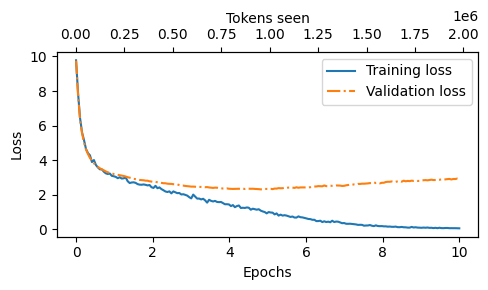

In [63]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Controlling randomness in the text generation

In [ ]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("The included lumbar and", tokenizer),
    max_new_tokens=25,
    context_size=CONFIG["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- Even if we execute the `generate_text_simple` function above multiple times, the LLM will always generate the same outputs
- We now introduce two concepts, so-called decoding strategies, to modify the `generate_text_simple`: *temperature scaling* and *top-k* sampling
- These will allow the model to control the randomness and diversity of the generated text

## Temperature scaling

- Previously, we always sampled the token with the highest probability as the next token using `torch.argmax`
- To add variety, we can sample the next token using The `torch.multinomial(probs, num_samples=1)`, sampling from a probability distribution
- Here, each index's chance of being picked corresponds to its probability in the input tensor

- Here's a little recap of generating the next token, assuming a very small vocabulary for illustration purposes:

In [ ]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

- We can control the distribution and selection process via a concept called temperature scaling
- "Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0
- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [ ]:
print_sampled_tokens(scaled_probas[1])

The rescaled probabilities via temperature 5 are more uniformly distributed

In [ ]:
print_sampled_tokens(scaled_probas[2])

## Top k sampling

To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')), 
    other=next_token_logits
)

print(new_logits)

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

## Modifying the text generation function

- The previous two subsections introduced temperature sampling and top-k sampling
- Let's use these two concepts to modify the `generate_simple` function we used to generate text via the LLM earlier, creating a new `generate` function:

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("The included lumbar and", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

## Loading and saving model weights in PyTorch

The recommended way in PyTorch is to save the model weights, the so-called `state_dict` via by applying the `torch.save` function to the `.state_dict()` method

In [ ]:
torch.save(model.state_dict(), "../models/model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("../models/model.pth", map_location=device, weights_only=True))
model.eval();

- It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
- These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "../models/model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("../models/model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();